# 03. MLP, Multi-Layer Perceptron — 從數學到 PyTorch

## 0. Notebook Header
- 作者：Paul Yang
- 目的：理解神經網路如何解決非線性問題 (XOR)，並掌握反向傳播 (Backpropagation) 的精隨。
- 學會什麼：Hidden Layer, Activation Function, Chain Rule, PyTorch nn.Sequential

## 1. 為什麼需要神經網路？(The XOR Problem)
我們之前學的 Linear/Logistic Regression 只能畫「一條直線」來分類。
但是，如果資料長得像 **XOR (互斥或)** 這樣，一條線是切不開的：
- (0, 0) -> 0
- (1, 1) -> 0
- (0, 1) -> 1
- (1, 0) -> 1

我們需要「彎曲」的線，這就是 **Hidden Layer (隱藏層)** 和 **Non-linear Activation (非線性激活函數)** 的工作。

X Shape: (4, 2)
y Shape: (4, 1)


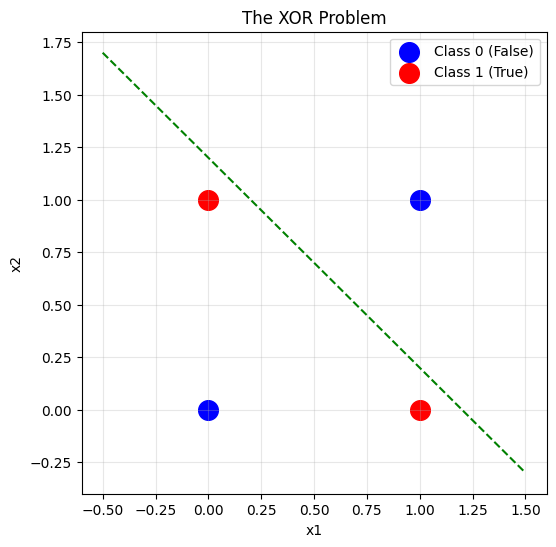

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 準備 XOR 資料
# 輸入 X: 4個點
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# 標籤 Y: XOR 的結果 (0, 1, 1, 0)
y = np.array([
    [0],
    [1],
    [1],
    [0]
])

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

fig, ax = plt.subplots(figsize=(6, 6))
# 2. 視覺化 XOR 問題

# 畫出 label 為 0 的點 (藍色)
ax.scatter(X[y.flatten()==0][:, 0], X[y.flatten()==0][:, 1], 
           color='blue', s=200, label='Class 0 (False)')

# 畫出 label 為 1 的點 (紅色)
ax.scatter(X[y.flatten()==1][:, 0], X[y.flatten()==1][:, 1], 
           color='red', s=200, label='Class 1 (True)')

ax.set_title("The XOR Problem")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.grid(True, alpha=0.3)

# 嘗試畫一條線看看能不能分開？(示意圖)
x_line = np.linspace(-0.5, 1.5, 100)
ax.plot(x_line, -x_line + 1.2, 'g--', label='Any Linear Line?') 

plt.show()

## 2.激活函數

### a. 純Python

In [7]:
import math

def step_function(x):
    return 1 if x>= 0 else 0

def relu(x):
    return max(0, x)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

print(f"Step(0.5) = {step_function(0.5)}")   # 應該是 1
print(f"Step(-2) = {step_function(-2)}")     # 應該是 0
print(f"ReLU(3) = {relu(3)}")                 # 應該是 3
print(f"ReLU(-1) = {relu(-1)}")               # 應該是 0
print(f"Sigmoid(5) = {sigmoid(5)}")          # 應該接近 1
print(f"Sigmoid(-5) = {sigmoid(-5)}")        # 應該接近 0
print(f"Sigmoid(0) = {sigmoid(0)}")          # 應該是 0.5

Step(0.5) = 1
Step(-2) = 0
ReLU(3) = 3
ReLU(-1) = 0
Sigmoid(5) = 0.9933071490757153
Sigmoid(-5) = 0.0066928509242848554
Sigmoid(0) = 0.5


### b. Numpy
為了讓這些數學公式能同時處理一整批資料

In [8]:
import numpy as np

def sigmoid_np(x):
    return 1 / (1 + np.exp(-x)) 

## 初始化

In [9]:
import numpy as np
import matplotlib.pyplot as plt

w1 = np.random.randn(2, 2)  # 2 inputs, 2 neurons
b1 = np.random.randn(2)     # 2 neurons

w2 = np.random.randn(2, 1)  # 2 inputs, 1 output
b2 = np.random.randn(1)     # 1 output

print(f"W1: {w1.shape}, b1: {b1.shape}")
print(f"W2: {w2.shape}, b2: {b2.shape}")

W1: (2, 2), b1: (2,)
W2: (2, 1), b2: (1,)


1. Input ($X$) $\to$ Hidden Layer: 線性變換 ($Z_1$) + 非線性激活 ($A_1$)
2. Hidden Layer ($A_1$) $\to$ Output Layer: 線性變換 ($Z_2$) + 非線性激活 ($A_2$)

In [10]:
def forward(X, w1, b1, w2, b2):
    z1 = np.dot(X, w1) + b1      # 第一層的線性組合
    a1 = sigmoid_np(z1)          # 第一層的激活函數
    z2 = np.dot(a1, w2) + b2      # 第二層的線性組合
    a2 = sigmoid_np(z2)          # 第二層的激活函數
    return a1, a2

## 3. 前向傳播 (Forward Propagation)

### 🧠 網路架構說明

我們的神經網路有 **1 個隱藏層**：

```
輸入層 (2) → 隱藏層 (2) → 輸出層 (1)
```

**重要概念**：
- ❓ **為什麼是 1 個隱藏層，而不是 2 個？**
  - 雖然我們使用了兩次激活函數（Sigmoid），但**激活函數不算作一層**
  - 隱藏層的數量 = 輸入層和輸出層之間的「權重矩陣」數量 - 1
  
- 📐 **層數的不同算法**：
  - 只算有權重的層：**2 層網路**（隱藏層 + 輸出層）
  - 包含輸入層：**3 層網路**（輸入層 + 隱藏層 + 輸出層）
  
- 🔄 **前向傳播的步驟**：
  1. **輸入 → 隱藏層**：$Z_1 = X \cdot W_1 + b_1$，然後 $A_1 = \sigma(Z_1)$
  2. **隱藏層 → 輸出層**：$Z_2 = A_1 \cdot W_2 + b_2$，然後 $A_2 = \sigma(Z_2)$

In [12]:
def backward(X, y, a1, a2, w2):
    m = X.shape[0]  # 樣本數量

    error2 = a2 - y  # 輸出層的誤差

    dw2 = np.dot(a1.T, error2) / m  # 第二層權重的梯度
    db2 = np.sum(error2, axis=0) / m  # 第二層偏置的梯度

    # 把誤差傳回第一層 (Backpropagate error)
    # 這裡要用到 Chain Rule:
    # (1) error2 乘上 w2 的轉置 (把責任分摊回去)
    # (2) 乘上 Sigmoid 的導數 (a1 * (1-a1))
    error1 = np.dot(error2, w2.T) * a1 * (1 - a1) 

    dw1 = np.dot(X.T, error1) / m  # 第一層權重的梯度
    db1 = np.sum(error1, axis=0) / m  # 第一層偏置的梯度

    return dw1, db1, dw2, db2

In [13]:
def train(X, y, epochs, learning_rate):
    np.random.seed(42)  # For reproducibility
    w1 = np.random.randn(2, 2)  # 2 inputs, 2 neurons
    b1 = np.random.randn(2)     # 2 neurons

    w2 = np.random.randn(2, 1)  # 2 inputs, 1 output
    b2 = np.random.randn(1)     # 1 output

    loss_history = []
    for epoch in range(epochs):
        a1 , a2 = forward(X, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = backward(X, y, a1, a2, w2)

        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2

        loss =  -(y * np.log(a2 + 1e-8) + (1 - y) * np.log(1 - a2 + 1e-8)).mean()
        loss_history.append(loss)
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return w1, b1, w2, b2, loss_history


In [14]:
w1, b1, w2, b2, loss_history = train(X, y, epochs=10000, learning_rate=0.1)

Epoch 0, Loss: 0.7983
Epoch 1000, Loss: 0.6842
Epoch 2000, Loss: 0.6020
Epoch 3000, Loss: 0.4744
Epoch 4000, Loss: 0.2589
Epoch 5000, Loss: 0.0932
Epoch 6000, Loss: 0.0510
Epoch 7000, Loss: 0.0344
Epoch 8000, Loss: 0.0258
Epoch 9000, Loss: 0.0205


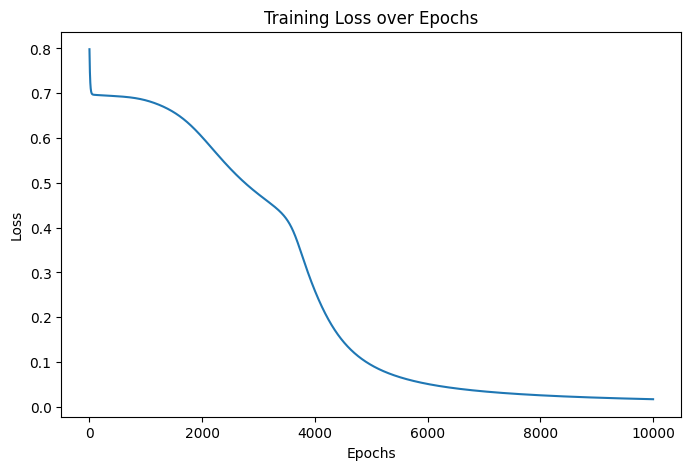

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_history)             
ax.set_title("Training Loss over Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()

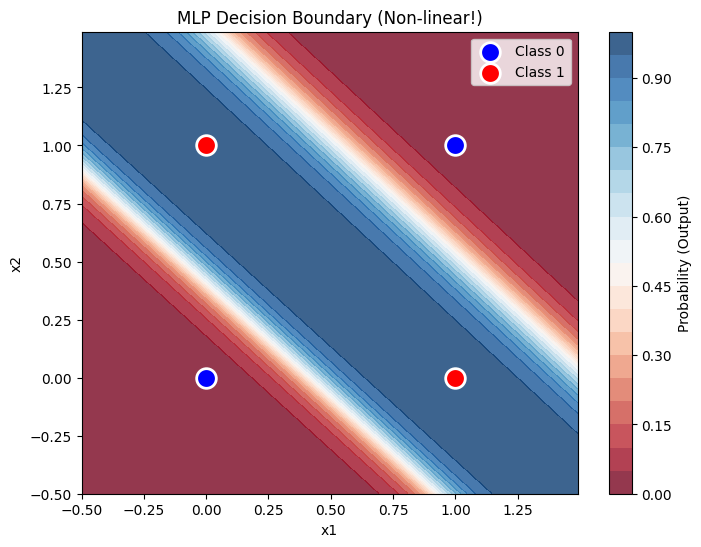

In [20]:
def plot_decision_boundary(X, y, w1, b1, w2, b2):
    # 1. 設定網格範圍 (比資料範圍稍微大一點)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01  # 網格密度
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # 2. 把網格點攤平，丟進模型預測
    grid_inputs = np.c_[xx.ravel(), yy.ravel()]
    
    # 注意：這裡我們只需要最終輸出 a2 (機率)
    _, probs = forward(grid_inputs, w1, b1, w2, b2)
    
    # 3. 把預測結果 reshape 回網格形狀
    probs = probs.reshape(xx.shape)
    
    # 4. 畫圖
    fig, ax = plt.subplots(figsize=(8, 6))

    # 畫出決策區域 (Contour Plot)
    # RdBu 是一個紅藍配色，中間白色代表 0.5 (決策邊界)
    cont = ax.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.8)
    fig.colorbar(cont, ax=ax, label='Probability (Output)')

    # 畫出原始資料點
    ax.scatter(X[y.flatten()==0][:, 0], X[y.flatten()==0][:, 1], 
               color='blue', s=200, edgecolor='white', linewidth=2, label='Class 0')
    ax.scatter(X[y.flatten()==1][:, 0], X[y.flatten()==1][:, 1], 
               color='red', s=200, edgecolor='white', linewidth=2, label='Class 1')

    ax.set_title("MLP Decision Boundary (Non-linear!)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    plt.show()

# 呼叫函式畫圖
plot_decision_boundary(X, y, w1, b1, w2, b2)

Hidden Layer Representations:
 [[5.25728835e-02 9.72182759e-04]
 [9.77873398e-01 8.40679668e-02]
 [9.74630943e-01 8.23778566e-02]
 [9.99967319e-01 8.94372963e-01]]


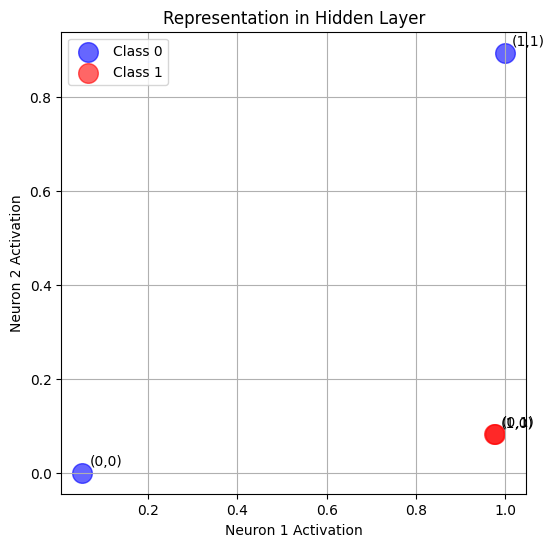

In [23]:
# 取得隱藏層的輸出 (a1)
hidden_features, _ = forward(X, w1, b1, w2, b2)

print("Hidden Layer Representations:\n", hidden_features)

fig, ax = plt.subplots(figsize=(6, 6))

# 畫出隱藏層空間中的點
# Class 0 (Blue)
ax.scatter(hidden_features[y.flatten()==0][:, 0], hidden_features[y.flatten()==0][:, 1], 
            color='blue', s=200, label='Class 0', alpha=0.6) # Add alpha to see overlaps

# Class 1 (Red)
ax.scatter(hidden_features[y.flatten()==1][:, 0], hidden_features[y.flatten()==1][:, 1], 
            color='red', s=200, label='Class 1', alpha=0.6)

# Add text annotations to identify each point
for i, txt in enumerate(['(0,0)', '(0,1)', '(1,0)', '(1,1)']):
    ax.annotate(txt, (hidden_features[i, 0], hidden_features[i, 1]), 
                xytext=(5, 5), textcoords='offset points')

ax.set_title("Representation in Hidden Layer")
ax.set_xlabel("Neuron 1 Activation")
ax.set_ylabel("Neuron 2 Activation")
ax.legend()
ax.grid(True)
plt.show()

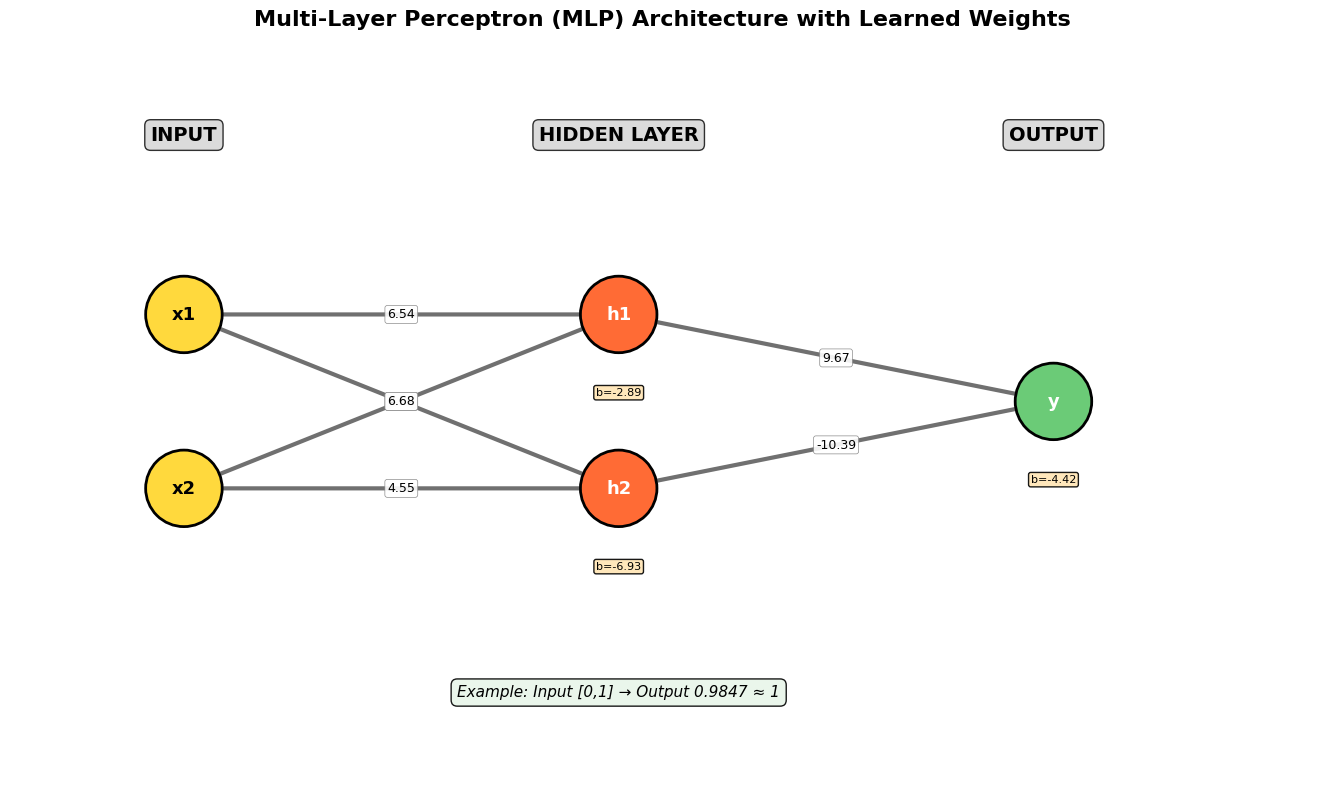

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.patches as mpatches

def visualize_network(w1, b1, w2, b2):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Layer positions - 更好的對齊
    input_pos = [(1, 2.5), (1, 1.5)]  # Input layer: x1, x2
    hidden_pos = [(3.5, 2.5), (3.5, 1.5)]  # Hidden layer: h1, h2
    output_pos = [(6, 2)]  # Output layer: y
    
    # Colors
    input_color = '#FFD93D'  # Yellow
    hidden_color = '#FF6B35'  # Orange
    output_color = '#6BCB77'  # Green
    
    # Draw connections from input to hidden (behind nodes)
    for i, input_p in enumerate(input_pos):
        for j, hidden_p in enumerate(hidden_pos):  # 2 hidden nodes
            weight = w1[i, j]
            linewidth = min(abs(weight) * 2, 3)  # Scale line width by weight magnitude
            alpha = min(abs(weight) * 0.4 + 0.3, 0.7)
            color = '#333333'
            
            arrow = FancyArrowPatch(input_p, hidden_p,
                                  arrowstyle='->', 
                                  mutation_scale=15,
                                  linewidth=linewidth,
                                  color=color,
                                  alpha=alpha,
                                  zorder=1)
            ax.add_patch(arrow)
            
            # 加上權重標籤
            mid_x = (input_p[0] + hidden_p[0]) / 2
            mid_y = (input_p[1] + hidden_p[1]) / 2
            ax.text(mid_x, mid_y, f'{weight:.2f}', 
                   fontsize=9, ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", 
                           edgecolor='gray', alpha=0.9, linewidth=0.5))
    
    # Draw connections from hidden to output
    for j, hidden_p in enumerate(hidden_pos):
        output_p = output_pos[0]
        weight = w2[j, 0]
        linewidth = min(abs(weight) * 2, 3)
        alpha = min(abs(weight) * 0.4 + 0.3, 0.7)
        color = '#333333'
        
        arrow = FancyArrowPatch(hidden_p, output_p,
                              arrowstyle='->', 
                              mutation_scale=15,
                              linewidth=linewidth,
                              color=color,
                              alpha=alpha,
                              zorder=1)
        ax.add_patch(arrow)
        
        # 加上權重標籤
        mid_x = (hidden_p[0] + output_p[0]) / 2
        mid_y = (hidden_p[1] + output_p[1]) / 2
        ax.text(mid_x, mid_y, f'{weight:.2f}', 
               fontsize=9, ha='center', va='center',
               bbox=dict(boxstyle="round,pad=0.2", facecolor="white", 
                       edgecolor='gray', alpha=0.9, linewidth=0.5))
    
    # Draw input nodes
    for i, pos in enumerate(input_pos):
        circle = Circle(pos, 0.22, color=input_color, ec='black', linewidth=2, zorder=5)
        ax.add_patch(circle)
        ax.text(pos[0], pos[1], f'x{i+1}', ha='center', va='center', 
               fontsize=13, fontweight='bold', zorder=6)
    
    # Draw hidden nodes
    for i, pos in enumerate(hidden_pos):
        circle = Circle(pos, 0.22, color=hidden_color, ec='black', linewidth=2, zorder=5)
        ax.add_patch(circle)
        ax.text(pos[0], pos[1], f'h{i+1}', ha='center', va='center', 
               fontsize=13, fontweight='bold', color='white', zorder=6)
        # 加上偏置值
        ax.text(pos[0], pos[1] - 0.45, f'b={b1[i]:.2f}', 
               fontsize=8, ha='center', va='center',
               bbox=dict(boxstyle="round,pad=0.2", facecolor="#FFE5B4", alpha=0.9))
    
    # Draw output node
    for i, pos in enumerate(output_pos):
        circle = Circle(pos, 0.22, color=output_color, ec='black', linewidth=2, zorder=5)
        ax.add_patch(circle)
        ax.text(pos[0], pos[1], 'y', ha='center', va='center', 
               fontsize=13, fontweight='bold', color='white', zorder=6)
        # 加上偏置值
        ax.text(pos[0], pos[1] - 0.45, f'b={b2[0]:.2f}', 
               fontsize=8, ha='center', va='center',
               bbox=dict(boxstyle="round,pad=0.2", facecolor="#FFE5B4", alpha=0.9))
    
    # Add layer labels
    ax.text(1, 3.5, 'INPUT', ha='center', fontsize=14, fontweight='bold', 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    ax.text(3.5, 3.5, 'HIDDEN LAYER', ha='center', fontsize=14, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    ax.text(6, 3.5, 'OUTPUT', ha='center', fontsize=14, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    # 加上預測結果示例
    test_input = np.array([[0, 1]])  # XOR: (0,1) should be 1
    _, prediction = forward(test_input, w1, b1, w2, b2)
    ax.text(3.5, 0.3, f'Example: Input [0,1] → Output {prediction[0][0]:.4f} ≈ 1', 
           fontsize=11, ha='center', style='italic',
           bbox=dict(boxstyle="round,pad=0.4", facecolor="#E8F5E9", alpha=0.9))
    
    ax.set_xlim(0, 7.5)
    ax.set_ylim(-0.2, 4)
    ax.set_aspect('equal')
    ax.set_title("Multi-Layer Perceptron (MLP) Architecture with Learned Weights", 
                fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the trained network
visualize_network(w1, b1, w2, b2)